# PAA Project, a.y. 2015/2016
## Average number of checks for Quicksort

Authors: Tommaso Papini (5537529), Gabriele Bani (5719258)


### Some initial imports

In [98]:
import numpy
from sympy import *
from sympy.abc import x, n, z, t, j, k

init_printing()

### Quicksort implementation with checks counting

In [99]:
def quick(v,l,r):
    #v is the array, l and r are the indexes of the quicksort (left and right)
    nc = 0; #nc is the number of checks made by the QuickSort Algorithm
    if r-l>=0:
        p = v[r]
        i = l-1
        j = r
        while i<j:
            i=i+1
            nc=nc+1
            while v[i]<p:
                i=i+1
                nc=nc+1
            j=j-1
            nc=nc+1
            while l<=j and p<v[j]:
                j=j-1
                nc=nc+1
            if i<j:
                a=v[i]
                v[i]=v[j]
                v[j]=a
        a=v[i]
        v[i]=p
        v[r]=a
        nc = nc + quick(v,l,i-1)
        nc = nc + quick(v,i+1,r)
    return nc

### Closed form to compute the average number of checks for Quicksort on an array of $n$ elements

In [100]:
def checks_quicksort(n):
    return 2*(n+1)*(harmonic(n+1).evalf()-1)

### A couple of examples

In [101]:
random_perm = numpy.random.permutation(20)
print ("Random array: %s" % (random_perm))
checks = quick(random_perm,0,19)
print ("Array after Quicksort: %s" % (random_perm))
print ("Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(20)))

Random array: [11  8  6 18  2  0 16 12  3 14  4 19 15  5 10 17  9  7 13  1]
Array after Quicksort: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Quicksort count: 111.00000; closed-form: 111.10507


In [102]:
random_perm = numpy.random.permutation(4)
print ("Random array: %s" % (random_perm))
checks = quick(random_perm,0,3)
print ("Array after Quicksort: %s" % (random_perm))
print ("Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(4)))

Random array: [3 0 2 1]
Array after Quicksort: [0 1 2 3]
Quicksort count: 12.00000; closed-form: 12.83333


### Main recurrence

#### Python version

In [135]:
def C_py(n):
    if n == 0:
        return 0
    else:
        Cn = 0.0
        for k in range(0, n):
            Cn += C_py(k)
        return n+1+(2.0/n)*Cn
random_perm = numpy.random.permutation(20)
import timeit
start1 = timeit.default_timer()
quicksort_count = quick(random_perm,0,19)
stop1 = timeit.default_timer()
start2 = timeit.default_timer()
checks = checks_quicksort(20)
stop2 = timeit.default_timer()
start3 = timeit.default_timer()
rec_quicksort = C_py(20)
stop3 = timeit.default_timer()
print ("Quicksort count: %.5f; closed-form: %.5f; recurrence: %.5f" % (quicksort_count, checks, rec_quicksort))
print ("Time Quicksort count: %.5f s; Time closed-form: %.5f s; Time recurrence: %.5f s" % (stop1 - start1,stop2 - start2,
                                                                                                                stop3-start3))

Quicksort count: 106.00000; closed-form: 111.10507; recurrence: 111.10507
Time Quicksort count: 0.00023 s; Time closed-form: 0.00033 s; Time recurrence: 0.79345 s


#### sympy version

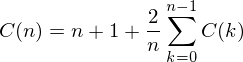

In [104]:
C_fun = Function('C')
base_rec = Eq(C_fun(n), n+1+(2/n)*Sum(C_fun(k), (k, 0, n-1)))
base_rec

#### Are we lucky?

In [105]:
print (rsolve(base_rec, C_fun(n), {C_fun(0):0}))

None


Nope... :(

### Recurrence solving (difference method)

#### Auxiliary function to apply the same operation to a number and two sided of an Eq

In [106]:
def do_both(eq, n, op):
    return Eq(op(eq.lhs, n), op(eq.rhs, n))

#### Multiply by n both sides

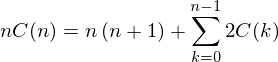

In [107]:
base_rec2 = do_both(base_rec, n, lambda x,y: x*y).simplify()
base_rec2

#### The above is valid forall $n$, so it's valid for $n-1$ as well

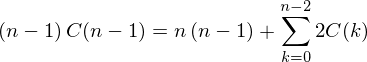

In [108]:
base_rec2_prev = base_rec2.subs(n, n-1).simplify()
base_rec2_prev

#### Auxiliary function to apply an operation to two Eqs sidewise

In [109]:
def do_eqs(eq1, eq2, op):
    return Eq(op(eq1.lhs, eq2.lhs), op(eq1.rhs, eq2.rhs))

#### Application of the difference method

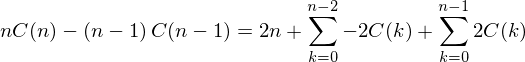

In [110]:
diff_rec = do_eqs(base_rec2, base_rec2_prev, lambda x,y: x-y).simplify()
diff_rec

#### Auxiliary function to extract the last term of a summation and substitute inside an Eq

In [111]:
def extract_last_term_subs(eq, old_sum):
    sum_args = old_sum.args
    f = sum_args[0]
    indexes = sum_args[1]
    new_sum = Sum(f, (indexes[0], indexes[1], indexes[2]-1)) + f.subs(indexes[0], indexes[2])
    return eq.subs(old_sum, new_sum)

#### Extract term $n-1$ and simplify summations

In [112]:
diff_rec2 = extract_last_term_subs(diff_rec, Sum(2*C_fun(k), (k, 0, n-1))).simplify().doit()
diff_rec2

#### Move $(n-1)C(n-1)$ to the other side and group by $C(n-1)$

In [113]:
new_rec = do_both(diff_rec2, (n-1)*C_fun(n-1), lambda x,y: x+y).simplify().factor(C_fun(n-1))
new_rec

#### Divide both sides by $n(n-1)$

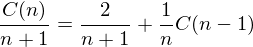

In [114]:
div_rec  = apart(do_both(new_rec, n*(n+1), lambda x,y: x/y), C_fun(n-1))
div_rec

#### Let's iterate!

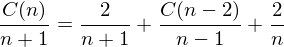

In [115]:
div_rec2 = div_rec.subs(C_fun(n-1)/n, div_rec.subs(n, n-1).rhs)
div_rec2

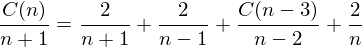

In [116]:
div_rec3 = div_rec2.subs(C_fun(n-2)/(n-1), div_rec.subs(n, n-2).rhs)
div_rec3

#### All the way to $C(0)$

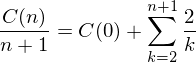

In [117]:
div_rec_final = Eq(div_rec.lhs, Sum(2/k, (k, 2, n+1))+C_fun(0)/(n-n+1))
div_rec_final

#### But $C(0)=0$ (initial condition)

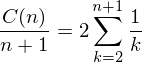

In [118]:
div_rec_final2 = div_rec_final.subs(C_fun(0), 0).factor()
div_rec_final2

#### Auxiliary function to add a missing first term in a summation and substitute inside an Eq

In [119]:
def add_missing_first_term_subs(eq, old_sum):
    sum_args = old_sum.args
    f = sum_args[0]
    indexes = sum_args[1]
    new_sum = Sum(f, (indexes[0], indexes[1]-1, indexes[2])) - f.subs(indexes[0], indexes[1]-1)
    return eq.subs(old_sum, new_sum)

#### Let's add the missing first term to the summation above

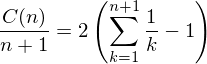

In [120]:
div_rec_final3 = add_missing_first_term_subs(div_rec_final2, Sum(1/k, (k, 2, n+1))).factor()
div_rec_final3

#### That summation above is the harmonic series!  

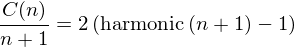

In [121]:
div_rec_final_harm = div_rec_final3.subs(Sum(1/k, (k, 1, n+1)),harmonic(n+1)).factor()
div_rec_final_harm

#### Multiply by n+1 both sides

In [122]:
final = do_both(div_rec_final_harm,n+1,lambda x,y: x*y).factor()
final